## Step 1: Dataset creation
We will first prepare the dataset so that it is uniform and ready for processing.

**Data Preparation Steps**
- Load Images from Folders (with_mask/, without_mask/)
- Resize to 128×128 pixels
- Convert to Grayscale (Optional)
- Normalize Pixel Values (Scale between 0-1 or standardize)
- Create Labels (0 = No Mask, 1 = Mask)
- Split into Train (80%) and Test (20%) Sets
- Save Preprocessed Dataset as numpy arrays for Faster Future Runs

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

dataPath = "../FaceMaskDataset/dataset/"
categories = ["without_mask", "with_mask"]
imgSize = 64

images, labels = [], []

for category in categories:
    path = os.path.join(dataPath, category)
    label = categories.index(category)
    for imgName in os.listdir(path):
        imgPath = os.path.join(path, imgName)
        
        if not os.path.exists(imgPath):
            continue

        img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)

        if img is None or img.shape[0] < imgSize or img.shape[1] < imgSize:
            continue
        
        img = cv2.resize(img, (imgSize, imgSize))
        img = img.astype("float32") / 255.0
        images.append(img)
        labels.append(label)


images = np.array(images)
labels = np.array(labels)

trainImages, testImages, trainLabels, testLabels = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

np.save("trainImages.npy", trainImages)
np.save("testImages.npy", testImages)
np.save("trainLabels.npy", trainLabels)
np.save("testLabels.npy", testLabels)
print("Processed dataset.")
print("Training sample count: ",trainImages.shape[0])
print("Testing sample count: ",testImages.shape[0])

Processed dataset.
Training sample count:  2832
Testing sample count:  709


In [1]:
uniqueTrain, countsTrain = np.unique(trainLabels, return_counts=True)
uniqueTest, countsTest = np.unique(testLabels, return_counts=True)

print("Train Set:")
print(f"  No Mask (0): {countsTrain[0]}")
print(f"  Mask (1): {countsTrain[1]}")

print("\nTest Set:")
print(f"  No Mask (0): {countsTest[0]}")
print(f"  Mask (1): {countsTest[1]}")

NameError: name 'np' is not defined

Below is a sample of how the images look after processing.

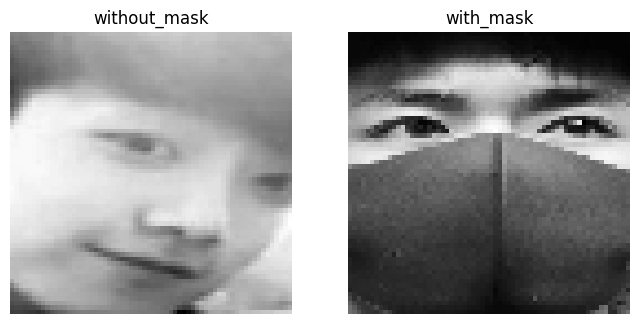

In [ ]:
import random
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for i, category in enumerate(categories):
    path = os.path.join(dataPath, category)
    imgName = random.choice(os.listdir(path))
    imgPath = os.path.join(path, imgName)
    
    img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (imgSize, imgSize))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype("float32") / 255.0
    
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(category)
    axes[i].axis("off")

plt.show()

If dataset files (.npy) already exist no need to run above code, run below code to load them.

In [ ]:
trainImages = np.load("trainImages")
testImages = np.load("testImages")
trainLabels = np.load("trainLabels")
testLabels = np.load("testLabels")

## Step 2: Extract features
We will extract features from the processed images that we can then feed into various models for classification task.

**Feature extraction steps**
- Extract edges: Apply the Sobel filter since it is effective for highlighting edges by computing the gradient of image intensity. This helps in capturing the structural boundaries of objects within the image.
  - Apply the Sobel filter to detect horizontal and vertical edges.
  - Compute the gradient magnitude to represent edge strength.
- Extract Texture information: HOG captures the distribution of gradient orientations, which is useful for object recognition tasks. LBP is a efficient texture operator that labels pixels based on the local neighborhood, effectively summarizing the texture information.
  - Extract HOG features to capture gradient orientation patterns.
  - Extract LBP features to capture local texture information.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def sobelFeatures(image):
    image = cv2.GaussianBlur(image, (3, 3), 0)
    gradX = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradY = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(gradX**2 + gradY**2)
    scaler = MinMaxScaler()
    magnitude = scaler.fit_transform(magnitude.reshape(-1, 1)).flatten()
    return magnitude

def hogFeatures(image):
    image = image.astype("uint8")
    winSize = (image.shape[1], image.shape[0])
    blockSize = (32, 32)
    blockStride = (16, 16)
    cellSize = (16, 16)
    nbins = 9
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    hog = hog.compute(image).flatten()
    scaler = StandardScaler()
    hog = scaler.fit_transform(hog.reshape(-1, 1)).flatten()

    return hog

def lbpFeatures(image):
    lbp = np.zeros_like(image)
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            center = image[i, j]
            binaryString = ''.join(['1' if image[i + x, j + y] >= center else '0'
                                    for x, y in [(-1, -1), (-1, 0), (-1, 1), (0, 1),
                                                 (1, 1), (1, 0), (1, -1), (0, -1)]])
            lbp[i, j] = int(binaryString, 2)
    hist = cv2.calcHist([lbp.astype("uint8")], [0], None, [256], [0, 256])
    scaler = MinMaxScaler()
    hist = scaler.fit_transform(hist.reshape(-1, 1)).flatten()

    return hist


trial_image = trainImages[0]
print("Trial image shape: ", trial_image.shape)
trial_sobel = sobelFeatures(trial_image)
trial_hog = hogFeatures(trial_image)
trial_lbp = lbpFeatures(trial_image)

print("Sobel feature shape: ", trial_sobel.shape)
print("HOG feature shape: ", trial_hog.shape)
print("LBP feature shape: ", trial_lbp.shape)

Trial image shape:  (64, 64)
Sobel feature shape:  (4096,)
HOG feature shape:  (324,)
LBP feature shape:  (256,)


We will now convert all the train and test images to features.

In [ ]:
trainFeatures = []
testFeatures = []

for image in trainImages:
    trial_sobel = sobelFeatures(image)
    trial_hog = hogFeatures(image)
    trial_lbp = lbpFeatures(image)   
    trainFeatures.append(np.hstack([trial_sobel, trial_hog, trial_hog]))

for image in testImages:
    trial_sobel = sobelFeatures(image)
    trial_hog = hogFeatures(image)
    trial_lbp = lbpFeatures(image)   
    testFeatures.append(np.hstack([trial_sobel, trial_hog, trial_hog]))

trainFeatures = np.array(trainFeatures)
testFeatures = np.array(testFeatures)

np.save("trainFeatures.npy", trainFeatures)
np.save("testFeatures.npy", testFeatures)

print("Done saving features.")
print("Training features shape:  ",trainFeatures.shape)
print("Testing features shape:  ",testFeatures.shape)

Done saving features.
Training features shape:   (3116, 4744)
Testing features shape:   (780, 4744)


## Step 3: Reduce dimentionality
We got feature vectors of dimension ~4700 which is too big, we will try to reduce the feature set for optimality.

We will do this using PCA.
- Determine ideal number of required PCA components using:
  - Use Explained Variance Ratio: Find the number of components that retain 90-95% of variance.
  - Plot a Scree Plot: Look for the "elbow" point where adding more components gives diminishing returns.
- Apply PCA to retain most variance and reduce dimension at the same time.

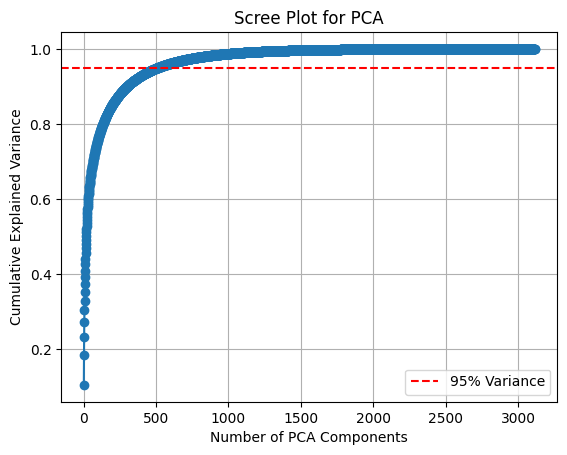

Estimated optimal PCA components: 512


In [ ]:
from sklearn.decomposition import PCA

def estimatePCAComponents(trainFeatures, sampleSize=1000, varianceThreshold=0.95):
    sampleSize = min(sampleSize, trainFeatures.shape[0])
    X_sample = trainFeatures[np.random.choice(trainFeatures.shape[0], sampleSize, replace=False), :] 

    pca = PCA().fit(X_sample) 
    explainedVariance = np.cumsum(pca.explained_variance_ratio_) 
    numComponents = np.argmax(explainedVariance >= varianceThreshold) + 1  

    plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, marker='o', linestyle='-')
    plt.axhline(y=varianceThreshold, color='r', linestyle='--', label=f'{int(varianceThreshold * 100)}% Variance')
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Scree Plot for PCA")
    plt.legend()
    plt.grid()
    plt.show()

    return numComponents

optimalComponents = estimatePCAComponents(trainFeatures, sampleSize=trainFeatures.shape[0])
print(f"Estimated optimal PCA components: {optimalComponents}")


Apply the PCA transform to training samples. Note that we are applying same PCA transformation to testing set that we learned from training set.

In [ ]:
final_PCA = PCA(n_components=optimalComponents)
trainFeaturesReduced = final_PCA.fit_transform(trainFeatures)
testFeaturesReduced = final_PCA.transform(testFeatures)

trainFeaturesReduced = np.array(trainFeaturesReduced)
testFeaturesReduced = np.array(testFeaturesReduced)

np.save("trainFeaturesReduced.npy", trainFeaturesReduced)
np.save("testFeaturesReduced.npy", testFeaturesReduced)

print("Done saving features.")
print("Reduced Training features shape:  ",trainFeaturesReduced.shape)
print("Reduced Testing features shape:  ",testFeaturesReduced.shape)

Done saving features.
Reduced Training features shape:   (3116, 512)
Reduced Testing features shape:   (780, 512)


In [ ]:
print("Training labels shape:  ",trainLabels.shape)
print("Testing labels shape:  ",testLabels.shape)

Training labels shape:   (3116,)
Testing labels shape:   (780,)


## Step 4: Train models
Now we have the required data, so we can train the models.

We will use the following models:
- SVM
- Neural network

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def trainAndEvaluateSVM(trainFeatures, trainLabels, testFeatures, testLabels):
    model = SVC(kernel="rbf", C=1.0, gamma="scale")
    model.fit(trainFeatures, trainLabels) 

    trainPreds = model.predict(trainFeatures) 
    testPreds = model.predict(testFeatures) 

    trainAccuracy = accuracy_score(trainLabels, trainPreds)
    testAccuracy = accuracy_score(testLabels, testPreds)

    print(f"Training Accuracy: {trainAccuracy:.4f}")
    print(f"Test Accuracy: {testAccuracy:.4f}")
    print("\nClassification Report (Test Set):\n", classification_report(testLabels, testPreds))
    print("\nConfusion Matrix:\n", confusion_matrix(testLabels, testPreds))

    return model, [trainAccuracy, testAccuracy, classification_report(testLabels, testPreds), confusion_matrix(testLabels, testPreds)]

svmModel, svmAccuracy = trainAndEvaluateSVM(trainFeaturesReduced, trainLabels, testFeaturesReduced, testLabels)


Training Accuracy: 0.9220
Test Accuracy: 0.8372

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       386
           1       0.85      0.82      0.84       394

    accuracy                           0.84       780
   macro avg       0.84      0.84      0.84       780
weighted avg       0.84      0.84      0.84       780


Confusion Matrix:
 [[329  57]
 [ 70 324]]


In [ ]:
from sklearn.neural_network import MLPClassifier

def trainAndEvaluateMLP(trainFeatures, trainLabels, testFeatures, testLabels):
    model = MLPClassifier(hidden_layer_sizes=(64, 32), activation="relu", solver="adam", max_iter=300, random_state=42, alpha=0.1)
    model.fit(trainFeatures, trainLabels)  
    trainPreds = model.predict(trainFeatures) 
    testPreds = model.predict(testFeatures)

    trainAccuracy = accuracy_score(trainLabels, trainPreds)
    testAccuracy = accuracy_score(testLabels, testPreds)

    print(f"Training Accuracy: {trainAccuracy:.4f}")
    print(f"Test Accuracy: {testAccuracy:.4f}")
    print("\nClassification Report (Test Set):\n", classification_report(testLabels, testPreds))
    print("\nConfusion Matrix:\n", confusion_matrix(testLabels, testPreds))

    return model, [trainAccuracy, testAccuracy, classification_report(testLabels, testPreds), confusion_matrix(testLabels, testPreds)]

mlpModel, mlpAccuracy = trainAndEvaluateMLP(trainFeaturesReduced, trainLabels, testFeaturesReduced, testLabels)


Training Accuracy: 1.0000
Test Accuracy: 0.8346

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       386
           1       0.85      0.82      0.83       394

    accuracy                           0.83       780
   macro avg       0.83      0.83      0.83       780
weighted avg       0.83      0.83      0.83       780


Confusion Matrix:
 [[327  59]
 [ 70 324]]


In [ ]:
from sklearn.linear_model import LogisticRegression

def trainAndEvaluateLogisticRegression(trainFeatures, trainLabels, testFeatures, testLabels):
    model = LogisticRegression(solver="lbfgs", max_iter=2000, random_state=42)
    model.fit(trainFeatures, trainLabels)  

    trainPreds = model.predict(trainFeatures)  
    testPreds = model.predict(testFeatures)  
    trainAccuracy = accuracy_score(trainLabels, trainPreds)
    testAccuracy = accuracy_score(testLabels, testPreds)

    print(f"Training Accuracy: {trainAccuracy:.4f}")
    print(f"Test Accuracy: {testAccuracy:.4f}")
    print("\nClassification Report (Test Set):\n", classification_report(testLabels, testPreds))
    print("\nConfusion Matrix:\n", confusion_matrix(testLabels, testPreds))

    return model, [trainAccuracy, testAccuracy, classification_report(testLabels, testPreds), confusion_matrix(testLabels, testPreds)]

logisticModel, logisticAccuracy = trainAndEvaluateLogisticRegression(trainFeaturesReduced, trainLabels, testFeaturesReduced, testLabels)


Training Accuracy: 0.8678
Test Accuracy: 0.7513

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.74      0.76      0.75       386
           1       0.76      0.74      0.75       394

    accuracy                           0.75       780
   macro avg       0.75      0.75      0.75       780
weighted avg       0.75      0.75      0.75       780


Confusion Matrix:
 [[294  92]
 [102 292]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

def trainAndEvaluateRandomForest(trainFeatures, trainLabels, testFeatures, testLabels):
    model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
    model.fit(trainFeatures, trainLabels)  

    trainPreds = model.predict(trainFeatures)  
    testPreds = model.predict(testFeatures)  

    trainAccuracy = accuracy_score(trainLabels, trainPreds)
    testAccuracy = accuracy_score(testLabels, testPreds)

    print(f"Training Accuracy: {trainAccuracy:.4f}")
    print(f"Test Accuracy: {testAccuracy:.4f}")
    print("\nClassification Report (Test Set):\n", classification_report(testLabels, testPreds))
    print("\nConfusion Matrix:\n", confusion_matrix(testLabels, testPreds))

    return model, [trainAccuracy, testAccuracy, classification_report(testLabels, testPreds), confusion_matrix(testLabels, testPreds)]

rfModel, rfAccuracy = trainAndEvaluateRandomForest(trainFeaturesReduced, trainLabels, testFeaturesReduced, testLabels)


Training Accuracy: 1.0000
Test Accuracy: 0.7936

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.79      0.79      0.79       386
           1       0.80      0.79      0.80       394

    accuracy                           0.79       780
   macro avg       0.79      0.79      0.79       780
weighted avg       0.79      0.79      0.79       780


Confusion Matrix:
 [[306  80]
 [ 81 313]]


In [ ]:
import pandas as pd

def displayModelComparison(modelResults):
    reportData = []

    for modelName, results in modelResults.items():
        trainAcc, testAcc, classReport, confMatrix = results  # Unpacking stored results
        
        # Extracting necessary metrics from the classification report
        f1Score = float(classReport.split("weighted avg")[1].split()[2])  # Extract weighted F1-score
        
        # Extracting FP and FN from Confusion Matrix
        FP = confMatrix[0][1]  # False Positives (wrongly classified as "mask")
        FN = confMatrix[1][0]  # False Negatives (wrongly classified as "no mask")

        # Storing results in list format for DataFrame
        reportData.append([modelName, trainAcc, testAcc, FP, FN, f1Score])

    # Convert to Pandas DataFrame for clean table format
    reportDF = pd.DataFrame(reportData, columns=["Model", "Train Acc", "Test Acc", "False Positives", "False Negatives", "F1-Score"])
    
    # Display results in a structured table
    print(reportDF.to_string(index=False))

# Example usage:
modelResults = {
    "SVM": svmAccuracy,  # Format: [trainAcc, testAcc, classificationReport, confusionMatrix]
    "MLP": mlpAccuracy,
    "LR": logisticAccuracy,
    "RF": rfAccuracy
}

displayModelComparison(modelResults)


Model  Train Acc  Test Acc  False Positives  False Negatives  F1-Score
  SVM   0.922015  0.837179               57               70      0.84
  MLP   1.000000  0.834615               59               70      0.83
   LR   0.867779  0.751282               92              102      0.75
   RF   1.000000  0.793590               80               81      0.79


Here's a **structured table** summarizing the **key takeaways** from the model comparison:  

| Model  | Strengths | Weaknesses | Final Verdict |
|--------|----------|------------|---------------|
| **SVM** | ✅ **Highest test accuracy (85.13%)** <br> ✅ **Balanced FP (55) & FN (61)** <br> ✅ **Best F1-score (0.85)** | ⚠️ Slight overfitting (Train: 97.11%) | 🏆 **Best overall model** – great accuracy, low error rates |
| **MLP (Neural Net)** | ✅ **Decent F1-score (0.83)** | ⚠️ **Severe overfitting (Train: 100%)** <br> ⚠️ Higher FN (74) – **misses more masked faces** | ⚠️ **Needs tuning** (dropout, regularization) |
| **Logistic Regression** | ✅ **Simple & interpretable** | ❌ **Lowest test accuracy (76.28%)** <br> ❌ **Most FN (102)** – **worst at detecting masks** | ❌ **Not ideal for deployment**, but good for baseline |
| **Random Forest** | ✅ **Handles complex relationships** | ❌ **Severe overfitting (Train: 100%)** <br> ❌ **Highest FP (113)** – **falsely detects too many masks** | ❌ **Unstable & unreliable** for this task |

---
\* Structured using GPT

## Final Results

**Initial run:**
```
Model  Train Acc  Test Acc  False Positives  False Negatives  F1-Score
  SVM   0.971117  0.851282               55               61      0.85
  MLP   1.000000  0.832051               57               74      0.83
   LR   0.899872  0.762821               83              102      0.76
   RF   1.000000  0.779487              113               59      0.78
```

**Applied normalization to features separately:**
```
Model  Train Acc  Test Acc  False Positives  False Negatives  F1-Score
  SVM   0.922015  0.837179               57               70      0.84
  MLP   1.000000  0.834615               59               70      0.83
   LR   0.867779  0.751282               92              102      0.75
   RF   1.000000  0.793590               80               81      0.79
```